## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [173]:
mylist= os.listdir('RawData/')
print(mylist)
len(mylist)

['03-01-02-01-01-01-01.wav', '03-01-02-01-01-01-02.wav', '03-01-02-01-01-01-03.wav', '03-01-02-01-01-01-04.wav', '03-01-02-01-01-01-05.wav', '03-01-02-01-01-01-06.wav', '03-01-02-01-01-01-07.wav', '03-01-02-01-01-01-08.wav', '03-01-02-01-01-01-09.wav', '03-01-02-01-01-01-10.wav', '03-01-02-01-01-01-11.wav', '03-01-02-01-01-01-12.wav', '03-01-02-01-01-01-13.wav', '03-01-02-01-01-01-14.wav', '03-01-02-01-01-01-15.wav', '03-01-02-01-01-01-16.wav', '03-01-02-01-01-01-17.wav', '03-01-02-01-01-01-18.wav', '03-01-02-01-01-01-19.wav', '03-01-02-01-01-01-20.wav', '03-01-02-01-01-01-21.wav', '03-01-02-01-01-01-22.wav', '03-01-02-01-01-01-23.wav', '03-01-02-01-01-01-24.wav', '03-01-02-01-01-02-01.wav', '03-01-02-01-01-02-02.wav', '03-01-02-01-01-02-03.wav', '03-01-02-01-01-02-04.wav', '03-01-02-01-01-02-05.wav', '03-01-02-01-01-02-06.wav', '03-01-02-01-01-02-07.wav', '03-01-02-01-01-02-08.wav', '03-01-02-01-01-02-09.wav', '03-01-02-01-01-02-10.wav', '03-01-02-01-01-02-11.wav', '03-01-02-01-01-02-

1440

In [174]:
type(mylist)

list

In [176]:
print(mylist[1200])

JK_a01.wav


In [178]:
print(mylist[1200][3:4])

a


## Plotting the audio file's waveform and its spectrogram

In [180]:
data, sampling_rate = librosa.load('RawData/KL_a02.wav')

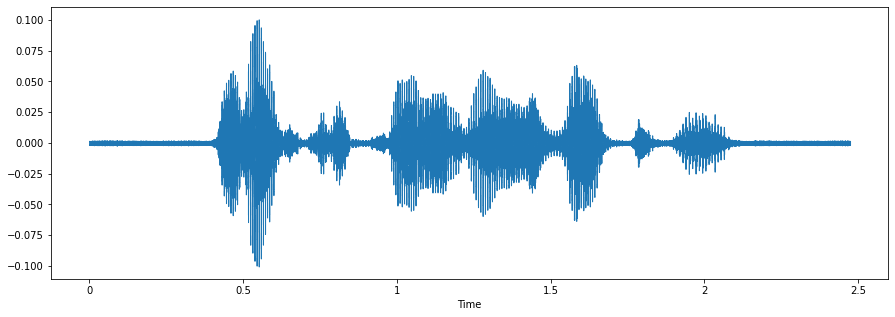

In [181]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

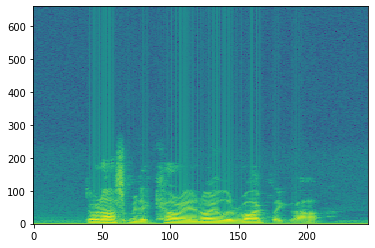

In [183]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/KL_a02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [184]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[3:4]=='a':
        feeling_list.append('male_angry')
    elif item[3:4]=='f':
        feeling_list.append('male_fearful')
    elif item[3:4]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[3:5]=='sa':
        feeling_list.append('male_sad')

In [185]:
labels = pd.DataFrame(feeling_list)

In [212]:
labels[:]
labels.groupby(0).count()

""
0
female_angry
female_calm
female_fearful
female_happy
female_sad
male_angry
male_calm
male_fearful
male_happy


## Getting the features of audio files using librosa

In [213]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][3:5]!='su' and mylist[index][3:4]!='n' and mylist[index][3:4]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [214]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.995125, -61.87015, -67.49628, ..."


In [215]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-58.802547,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-38.301632,-39.792603,-40.614017,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-29.195793,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.872478,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-33.819771,-39.072914,-41.896793,-40.866905,-38.293262,-36.375122,-37.914906,-40.027390,-43.315861,-44.848808


In [216]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-58.802547,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-38.301632,-39.792603,-40.614017,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-29.195793,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.872478,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-33.819771,-39.072914,-41.896793,-40.866905,-38.293262,-36.375122,-37.914906,-40.027390,-43.315861,-44.848808


In [217]:
newdf = pd.concat([df3,labels], axis=1)

In [218]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [219]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792603,-40.614017,-41.209984,-41.439613,-43.994675,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348972,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674789,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007893,...,-39.072914,-41.896793,-40.866905,-38.293262,-36.375122,-37.914906,-40.027390,-43.315861,-44.848808,male_calm


In [220]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
479,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,-67.128098,...,-52.192722,-53.083382,-54.695763,-52.385254,-53.176041,-54.981583,-54.078629,-54.264133,-57.056099,female_sad
1116,1.876094,-0.836856,-5.443649,-8.037951,-11.432100,-13.335198,-18.141024,-21.592182,-23.681923,-20.913670,...,-6.537559,-6.440283,-5.816414,-5.930071,-6.275980,-6.340057,-6.432978,-7.028987,-8.175652,male_happy
349,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,-47.939190,...,-39.217716,-41.336765,-43.327446,-44.895145,-46.341850,-46.351578,-46.122383,-45.796871,-45.821953,female_happy
26,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,-65.303253,...,-37.281231,-38.535637,-40.021580,-40.174664,-41.068069,-40.677696,-41.743942,-42.340263,-44.397686,male_calm
878,-51.422340,-46.735233,-45.134861,-45.604927,-45.115391,-44.593533,-45.553974,-45.842999,-45.718510,-46.048405,...,-38.503738,-39.524296,-40.020390,-41.529324,-42.963005,-42.646137,-42.776268,-38.107887,-31.528776,male_fearful
157,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,-74.444916,...,-61.265488,-61.317276,-60.597134,-60.337418,-62.790710,-67.382622,-69.709412,-69.842964,-69.001152,female_calm
632,-57.262810,-57.580288,-55.711014,-56.019207,-57.421635,-55.191589,-55.619637,-55.186565,-54.398800,-56.593533,...,-48.170616,-48.727863,-48.560032,-48.305271,-48.208603,-50.128883,-50.855473,-54.643082,-56.456539,male_angry
269,-54.292175,-53.038567,-53.512924,-53.126484,-54.015057,-54.318539,-55.030495,-56.599686,-56.698277,-56.190693,...,-55.310440,-55.653328,-53.803165,-52.699326,-51.941406,-51.811363,-53.280098,-55.385403,-58.129971,female_happy
257,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,...,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,-64.934372,female_happy
1159,-33.243973,-36.080757,-40.354553,-40.361820,-40.849506,-40.419052,-40.415840,-39.882767,-39.214027,-29.443356,...,-39.043880,-38.540760,-40.386356,-38.438725,-38.937229,-40.401413,-39.007240,-37.358818,-32.658344,male_fearful


In [221]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [222]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [223]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
751,-44.725876,-44.672832,-44.600388,-45.753319,-44.904640,-45.171577,-45.176399,-44.742813,-44.610985,-43.578411,...,-47.246902,-45.484554,-45.256920,-45.362724,-44.978306,-44.990215,-43.417522,-44.223213,-43.672276,female_angry
478,-65.827278,-65.827278,-65.827278,-65.827278,-65.827278,-65.827278,-65.827278,-65.827278,-65.827278,-65.823341,...,-53.029148,-52.416824,-52.295540,-54.714592,-55.002075,-51.639061,-50.514690,-49.591232,-52.641747,male_sad
130,-66.106758,-61.367912,-60.197758,-60.956905,-61.256386,-60.524029,-60.204308,-61.910885,-64.986221,-68.658829,...,-54.575356,-54.652634,-50.186661,-51.969601,-53.514954,-53.341072,-54.337620,-53.015537,-56.352272,male_calm
780,-61.246391,-60.313168,-60.542480,-63.737144,-64.673180,-61.401402,-62.801926,-64.522797,-64.676834,-63.780857,...,-58.870510,-61.683842,-59.392471,-58.266647,-60.922829,-64.676834,-64.676834,-64.676834,-64.676834,male_fearful
118,-61.713039,-60.084797,-61.100246,-61.264297,-63.234463,-64.450417,-64.190735,-61.222492,-57.964939,-56.499588,...,-21.276955,-22.493227,-22.733643,-23.739727,-24.691914,-24.513231,-24.660103,-21.845039,-19.238777,male_calm
20,-50.145851,-51.725094,-57.662331,-57.435478,-55.386177,-58.720501,-59.810463,-57.134995,-53.734188,-52.679893,...,-30.711119,-29.367380,-32.856697,-33.950638,-31.564322,-31.977119,-33.474689,-31.985491,-34.371613,male_calm
1171,-25.826534,-26.369354,-29.872103,-30.631502,-30.904926,-30.482054,-28.779432,-27.924032,-30.520653,-34.738026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_happy
548,-54.708679,-54.656719,-52.726292,-51.454319,-51.366665,-46.573868,-45.788761,-50.594242,-51.468876,-52.202538,...,-25.084791,-24.532766,-22.931753,-23.041199,-24.449684,-27.639610,-28.013048,-24.620104,-22.980385,male_sad
469,-59.493393,-53.362549,-50.129047,-51.201130,-53.823051,-54.843216,-54.623421,-54.521767,-53.647213,-52.595947,...,-58.779076,-56.992493,-57.373470,-61.223671,-59.423950,-58.873928,-61.258366,-61.367977,-60.633762,female_sad
579,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,-54.134827,...,-53.893734,-54.098728,-53.958939,-53.267456,-53.393112,-53.997086,-54.044296,-53.470013,-54.072098,female_angry


In [224]:
trainfeatures = train.iloc[:, :-1]

In [225]:
trainlabel = train.iloc[:, -1:]

In [226]:
testfeatures = test.iloc[:, :-1]

In [227]:
testlabel = test.iloc[:, -1:]

In [228]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

#y_train = [str(label) for label in y_train]
#y_test = [str(label) for label in y_test]

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


c:\Users\c-ala\.conda\envs\Athena\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\c-ala\.conda\envs\Athena\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [229]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [230]:
X_train.shape

(958, 216)

## Padding sequence for CNN model

In [244]:
print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [245]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [246]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_42 (Conv1D)          (None, 216, 128)          768       
                                                                 
 activation_49 (Activation)  (None, 216, 128)          0         
                                                                 
 conv1d_43 (Conv1D)          (None, 216, 128)          82048     
                                                                 
 activation_50 (Activation)  (None, 216, 128)          0         
                                                                 
 dropout_14 (Dropout)        (None, 216, 128)          0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [247]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [248]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=1250, validation_data=(x_testcnn, y_test))

Epoch 1/1250
15/15 [==============================] - 2s 66ms/step - loss: 2.4439 - accuracy: 0.0866 - val_loss: 2.3171 - val_accuracy: 0.1488
Epoch 2/1250
15/15 [==============================] - 1s 58ms/step - loss: 2.3571 - accuracy: 0.0992 - val_loss: 2.2935 - val_accuracy: 0.1322
Epoch 3/1250
15/15 [==============================] - 1s 57ms/step - loss: 2.3191 - accuracy: 0.1065 - val_loss: 2.2798 - val_accuracy: 0.1157
Epoch 4/1250
15/15 [==============================] - 1s 60ms/step - loss: 2.3123 - accuracy: 0.1263 - val_loss: 2.2708 - val_accuracy: 0.1281
Epoch 5/1250
15/15 [==============================] - 1s 60ms/step - loss: 2.2975 - accuracy: 0.1347 - val_loss: 2.2631 - val_accuracy: 0.1736
Epoch 6/1250
15/15 [==============================] - 1s 61ms/step - loss: 2.2983 - accuracy: 0.1148 - val_loss: 2.2545 - val_accuracy: 0.1777
Epoch 7/1250
15/15 [==============================] - 1s 61ms/step - loss: 2.2738 - accuracy: 0.1503 - val_loss: 2.2484 - val_accuracy: 0.2231

## Plotting the accuracy and loss graph

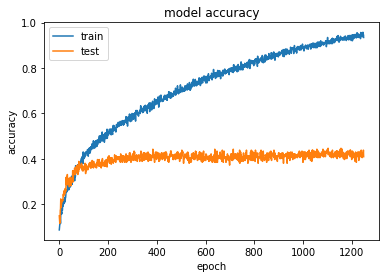

In [249]:
#sigmoid
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

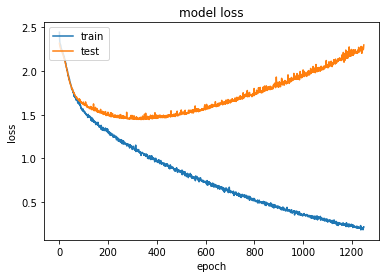

In [250]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [251]:
from tensorflow.keras.models import load_model

model_name = 'Emotion_Voice_Detection_Model_TWO.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

model=load_model('saved_models/Emotion_Voice_Detection_Model.h5')   
print('Saved trained model at %s ' % model_path)

Saved trained model at c:\Users\c-ala\Documents\_GitHub\Cesar514\MultiEmotion Pipeline\Voice\Voice-Emotion-Detector\saved_models\Emotion_Voice_Detection_Model_TWO.h5 


## Predicting emotions on the test data

In [252]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

8/8 [==============================] - 0s 10ms/step


In [253]:
preds

array([[9.3632954e-04, 2.3145310e-03, 2.2213566e-05, ..., 3.0083541e-07,
        1.7438877e-06, 1.1885621e-05],
       [3.5305479e-07, 2.7003209e-16, 9.2931739e-14, ..., 6.7710966e-01,
        3.7552037e-03, 1.5644661e-01],
       [1.4942289e-08, 5.7614034e-09, 9.9997640e-01, ..., 1.6156390e-10,
        2.6866340e-13, 3.2447070e-13],
       ...,
       [2.0359322e-01, 7.5196105e-01, 1.9722912e-02, ..., 4.3088248e-06,
        4.1254742e-07, 5.1783205e-05],
       [9.8598540e-01, 8.0251452e-03, 3.6222352e-07, ..., 1.3913714e-05,
        6.6616813e-05, 1.5138857e-03],
       [1.0558078e-07, 9.4933778e-01, 2.8117605e-05, ..., 9.0748678e-08,
        2.5707710e-08, 5.0235644e-07]], dtype=float32)

In [254]:
preds1=preds.argmax(axis=1)

In [255]:
preds1

array([4, 7, 2, 5, 0, 6, 4, 7, 8, 1, 0, 3, 9, 3, 3, 5, 4, 5, 6, 7, 5, 3,
       0, 9, 8, 9, 7, 8, 1, 8, 4, 1, 2, 7, 9, 3, 2, 7, 8, 0, 6, 4, 7, 9,
       4, 9, 8, 7, 2, 9, 1, 9, 0, 5, 0, 3, 2, 4, 8, 7, 6, 8, 5, 0, 6, 2,
       2, 3, 6, 9, 3, 8, 7, 0, 9, 0, 8, 9, 2, 6, 3, 4, 0, 3, 5, 3, 1, 8,
       6, 0, 4, 8, 1, 7, 2, 9, 5, 9, 7, 5, 3, 1, 9, 8, 1, 7, 3, 5, 9, 0,
       0, 9, 9, 8, 2, 0, 2, 6, 5, 9, 4, 9, 9, 5, 4, 9, 0, 1, 7, 0, 4, 5,
       5, 2, 5, 4, 7, 0, 5, 6, 6, 7, 9, 4, 1, 7, 2, 8, 2, 7, 9, 9, 6, 2,
       2, 3, 9, 0, 1, 1, 8, 8, 5, 3, 8, 8, 5, 9, 4, 5, 4, 1, 1, 3, 6, 8,
       1, 1, 5, 7, 4, 5, 6, 2, 1, 5, 5, 3, 7, 7, 2, 5, 7, 9, 7, 2, 8, 9,
       3, 5, 5, 0, 7, 8, 7, 9, 5, 7, 5, 8, 8, 4, 9, 5, 0, 7, 3, 4, 3, 4,
       4, 3, 4, 0, 2, 5, 2, 5, 1, 3, 6, 7, 9, 8, 6, 9, 1, 1, 4, 1, 0, 1],
      dtype=int64)

In [256]:
abc = preds1.astype(int).flatten()

In [257]:
predictions = (lb.inverse_transform((abc)))

In [258]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_sad
1,male_fearful
2,female_fearful
3,male_angry
4,female_angry
5,male_calm
6,female_sad
7,male_fearful
8,male_happy
9,female_calm


In [259]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [260]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_sad
1,male_fearful
2,female_fearful
3,male_angry
4,female_angry
5,male_calm
6,female_sad
7,male_fearful
8,male_happy
9,female_calm


In [261]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [262]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_sad,female_sad
171,female_calm,female_calm
172,female_calm,female_calm
173,female_happy,female_happy
174,male_calm,male_calm
175,male_happy,male_happy
176,female_fearful,female_calm
177,female_calm,female_calm
178,male_angry,male_angry
179,male_fearful,male_fearful


In [263]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,20
female_calm,20
female_fearful,21
female_happy,26
female_sad,19
male_angry,30
male_calm,17
male_fearful,31
male_happy,26


In [264]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,22
female_calm,22
female_fearful,21
female_happy,22
female_sad,23
male_angry,31
male_calm,16
male_fearful,28
male_happy,25


In [265]:
finaldf.to_csv('Predictions.csv', index=False)

In [276]:
mylist= os.listdir('../../')
print(mylist)

['Audio2', 'Face Classification', 'Video1', 'Voice']


In [315]:
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
from math import ceil
import os  # Ensure os is imported

video_path = "..\..\Video1\Angry_video.mp4"  # Change this to the path of your video file
audio_path = "..\..\Audio2\emotion.mp3"  # Output path for the extracted audio

# Load the video file and extract the audio
video_clip = VideoFileClip(video_path)
audio_clip = video_clip.audio
audio_clip.write_audiofile(audio_path)

audio_clip.close()
video_clip.close()

# Load the extracted audio
audio = AudioSegment.from_file(audio_path)

# Define the length of each chunk in milliseconds
chunk_length_ms = 3000

# Calculate the number of chunks needed
num_chunks = ceil(len(audio) / chunk_length_ms)

# Split the audio and save each chunk
for i in range(num_chunks):
    start_time = i * chunk_length_ms
    end_time = min((i + 1) * chunk_length_ms, len(audio))
    chunk = audio[start_time:end_time]
    chunk_name = f'..\..\Audio2\chunk_{i+1}.mp3'  # Naming each chunk
    chunk.export(chunk_name, format="mp3")
    print(f'Exported {chunk_name}')

# After exporting all chunks, delete the original audio file
os.remove(audio_path)
print(f'Deleted original audio file at {audio_path}')

MoviePy - Writing audio in ..\..\Audio2\emotion.mp3


MoviePy - Done.


Exported ..\..\Audio2\chunk_1.mp3
Exported ..\..\Audio2\chunk_2.mp3
Exported ..\..\Audio2\chunk_3.mp3
Deleted original audio file at ..\..\Audio2\emotion.mp3


In [316]:
import os
import pandas as pd
import numpy as np
import librosa

# Directory where the chunks are saved
chunks_dir = '../../Audio2'
audio_files = [f for f in os.listdir(chunks_dir) if f.endswith('.mp3')]
audio_files.sort()  # Optional, to process the files in a sorted order

df = pd.DataFrame(columns=['feature'])
bookmark = 0

for index, filename in enumerate(audio_files):
    # Adjust the condition according to your naming convention, if needed
    file_path = os.path.join(chunks_dir, filename)
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    df.loc[bookmark] = [feature]
    bookmark += 1

# Now, df contains the features extracted from each audio chunk


In [317]:
print(df)
df = pd.DataFrame(df['feature'].values.tolist())
df[:]
df.fillna('0')


                                             feature
0  [-11.966818, -12.856741, -13.469955, -14.61296...
1  [-20.965061, -17.918777, -14.978057, -11.24258...
2  [-18.874561, -16.582762, -16.271801, -15.99333...


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-11.966818,-12.856741,-13.469955,-14.612967,-14.548982,-13.776064,-14.109504,-13.697931,-14.953203,-15.198351,...,-16.089672,-14.583381,-14.114948,-15.439845,-14.611379,-16.038618,-17.027634,-17.913363,-16.94627,-19.489918
1,-20.965061,-17.918777,-14.978057,-11.242580,-10.337305,-13.382786,-16.785479,-16.344145,-12.966872,-6.747217,...,-17.079094,-16.375471,-16.542969,-16.555483,-16.155872,-16.678062,-17.789188,-19.267206,-17.440832,-17.140402
2,-18.874561,-16.582762,-16.271801,-15.993337,-16.474506,-15.716786,-15.937692,-15.861182,-17.579344,-16.412031,...,0,0,0,0,0,0,0,0,0,0


In [318]:
x_traincnn =np.expand_dims(df, axis=2)

In [320]:
preds = model.predict(x_traincnn, batch_size=1, verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:]

3/3 [==============================] - 0s 2ms/step


,predictedvalues
0,male_fearful
1,male_angry
2,female_angry


In [321]:
# Assuming preddf is your DataFrame
# Remove 'male_' and 'female_' prefixes from the 'predictedvalues' column
preddf['predictedvalues'] = preddf['predictedvalues'].str.replace('female_', '').str.replace('male_', '')

# Calculate the percentage of each emotion
emotion_counts = preddf['predictedvalues'].value_counts(normalize=True) * 100

# Convert the emotion_counts to a DataFrame for nicer formatting, if desired
emotion_percentage_df = emotion_counts.reset_index().rename(columns={'index': 'emotion', 'predictedvalues': 'percentage'})

# Display the emotion percentage DataFrame
print(emotion_percentage_df)


  percentage  proportion
0      angry   66.666667
1    fearful   33.333333
